# Finding Swiss municipalities which names are also English Words

In [78]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from PyDictionary import PyDictionary
from io import StringIO
import sys
import os.path
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point
import adjustText

In [3]:
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

In [4]:
def isEnglishWord(s):
    with Capturing() as output:
        dictionary.meaning(s)
    return output == []

## Matching municipalities with an english dictionary

In [5]:
df = pd.read_csv("./towns.csv")
dictionary = PyDictionary()

In [6]:
munis_english_words_path = 'municipalities_english_words.txt'
if(not os.path.exists(munis_english_words_path)):
    print("Computing municipalities...")
    municipalities_english_words = []
    for index, row in df.iterrows():
        municipality = row['Municipality']
        if(isEnglishWord(municipality)):
            municipalities_english_words.append(municipality)

    with open(munis_english_words_path, 'w') as filehandle:
        for muni in municipalities_english_words:
            filehandle.write('%s\n' % muni)
else:
    print("Retrieved computed municipalities from file")
    municipalities_english_words = []
    with open(munis_english_words_path, 'r') as filehandle:
        for line in filehandle:
            # remove linebreak which is the last character of the string
            currentPlace = line[:-1]
            municipalities_english_words.append(currentPlace)

Retrieved computed municipalities from file


## Handpicking which entries make sense
I chose to remove Units and proper nouns from the selected list, as they don't typically correspond to what we think about when thinking about english words

In [7]:
filtered_munis_path = "filtered_munis.txt"
if(not os.path.exists(filtered_munis_path)):
    #Filtering the results
    munis_deleting_decision = []

    for muni in municipalities_english_words:
        print(muni)
        print(dictionary.meaning(muni))
        keep = input("Keep?")
        munis_deleting_decision.append((muni, keep))

    filtered_muni_list = []
    for muni in munis_deleting_decision:
        if muni[1] == 'y': # y = keep
            filtered_muni_list.append(muni[0])

    with open(filtered_munis_path) as filehandle:
            for muni in filtered_muni_list:
                filehandle.write('%s\n' % muni)
else:
    print("Retrieved computed municipalities from file")
    filtered_muni_list = []
    with open(filtered_munis_path, 'r') as filehandle:
        for line in filehandle:
            # remove linebreak which is the last character of the string
            currentPlace = line[:-1]
            filtered_muni_list.append(currentPlace)

Retrieved computed municipalities from file


## Display data on map

In [53]:
#building a list of coordinates for the filtered entries
geolocator = Nominatim(user_agent="Finding_Swiss_Towns_With_English_names")
locations = pd.DataFrame([], columns = ['municipality', 'longitude', 'latitude'])

for i in range(len(filtered_muni_list)):
    muni = filtered_muni_list[i]
    location = geolocator.geocode(muni + " Switzerland", timeout=10)
    locations.loc[i] = [muni, location.longitude, location.latitude]
    
muni_points = [Point(xy) for xy in zip(locations["longitude"], locations["latitude"])]
muni_points = gpd.GeoDataFrame(locations, geometry=muni_points)

In [64]:
switzerland = gpd.read_file("switzerland-geojson/country/switzerland.geojson")
lakes = gpd.read_file("switzerland-geojson/lakes/lake-baldegg.geojson")
for file in os.listdir("switzerland-geojson/lakes"):
    lake = gpd.read_file("switzerland-geojson/lakes/" + file)
    lakes = lakes.append(lake)

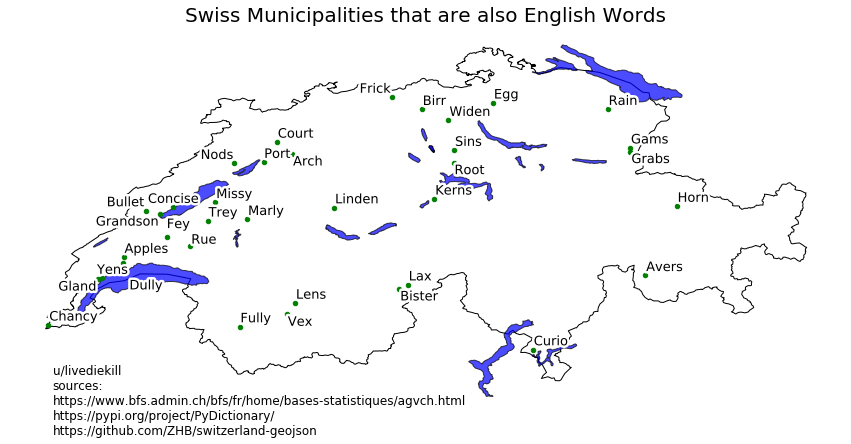

In [112]:
fig, ax = plt.subplots(figsize=(15,10))
plt.title("Swiss Municipalities that are also English Words", fontsize=20)
plt.text(6, 45.5, "u/livediekill\nsources:\nhttps://www.bfs.admin.ch/bfs/fr/home/bases-statistiques/agvch.html\nhttps://pypi.org/project/PyDictionary/\nhttps://github.com/ZHB/switzerland-geojson",
        fontsize=12)
plt.axis('off')
switzerland.plot(ax=ax, color="white", edgecolor='black')
lakes.plot(ax=ax, color="blue", edgecolor="black", alpha=0.7)
muni_points.plot(ax=ax, markersize=20, color='green')
labels = [ax.text(row['longitude'], row['latitude'], str(row['municipality']), fontsize=13) for index, row in muni_points.iterrows()]
adjustText.adjust_text(labels)
for label in labels:
    label.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
plt.savefig("Switzerland.png",bbox_inches='tight',dpi=100)